In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
LR = 0.5
MAX_EPOCH = 100
BATCH_SIZE = 10000

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
class Approximator(nn.Module):
    def __init__(self):
        super(Approximator, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 100),
                                       #nn.Tanh(),
                                       nn.ReLU(inplace = True),
                                       #nn.Sigmoid(),
                                       nn.Linear(100, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output

In [4]:
X = np.linspace(-10,10,100000)
y = X**4

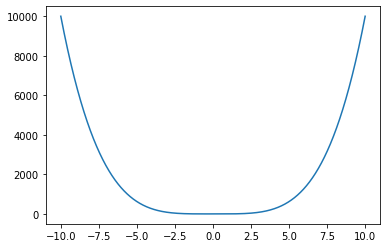

In [5]:
plt.plot(X,y)
plt.show()

In [6]:
X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2))
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)

def get_DataFrame(array_1, array_2):
  df = pd.DataFrame()
  
  df["X"] = array_1
  df["y"] = array_2
  
  df = df.sort_values("X")

  return df

In [7]:
model = Approximator().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction="mean")

In [8]:
# training loop
train_loss_list = list()
val_loss_list = list()
convergence = list()

for epoch in range(MAX_EPOCH):
    model.train()
    # training loop

    temp_loss_list = list()
    
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        optimizer.zero_grad()

        score = model(X_train)
        loss = criterion(input=score, target=y_train)
        loss.backward()

        optimizer.step()

        temp_loss_list.append(loss.detach().cpu().numpy())
        
    train_loss_list.append(np.average(temp_loss_list))

    if epoch % 1 == 0:
      convergence.append( get_DataFrame( X_train.detach().numpy().squeeze() , score.detach().numpy().squeeze()))

    # validation
    model.eval()
    
    temp_loss_list = list()
    for X_val, y_val in val_dataloader:
        X_val = X_val.type(torch.float32).to(device)
        y_val = y_val.type(torch.float32).to(device)

        score = model(X_val)
        loss = criterion(input=score, target=y_val)

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    val_loss_list.append(np.average(temp_loss_list))

    if epoch % 1 == 0:
      print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
      print("\ttrain loss: %.5f" % train_loss_list[-1])
      print("\tval loss: %.5f" % val_loss_list[-1])

epoch 1 / 100
	train loss: 7054309.00000
	val loss: 4554364.00000
epoch 2 / 100
	train loss: 3761661.00000
	val loss: 3476365.50000
epoch 3 / 100
	train loss: 3108240.25000
	val loss: 2655039.25000
epoch 4 / 100
	train loss: 2561772.00000
	val loss: 2330926.00000
epoch 5 / 100
	train loss: 2191079.50000
	val loss: 1969917.50000
epoch 6 / 100
	train loss: 1829248.87500
	val loss: 1649957.50000
epoch 7 / 100
	train loss: 1485599.50000
	val loss: 1290102.25000
epoch 8 / 100
	train loss: 1151881.12500
	val loss: 981375.43750
epoch 9 / 100
	train loss: 865569.00000
	val loss: 725209.62500
epoch 10 / 100
	train loss: 635614.43750
	val loss: 530859.75000
epoch 11 / 100
	train loss: 466142.12500
	val loss: 390780.53125
epoch 12 / 100
	train loss: 346587.37500
	val loss: 294880.06250
epoch 13 / 100
	train loss: 262891.87500
	val loss: 225387.01562
epoch 14 / 100
	train loss: 203277.71875
	val loss: 176963.81250
epoch 15 / 100
	train loss: 158799.76562
	val loss: 140017.71875
epoch 16 / 100
	tra

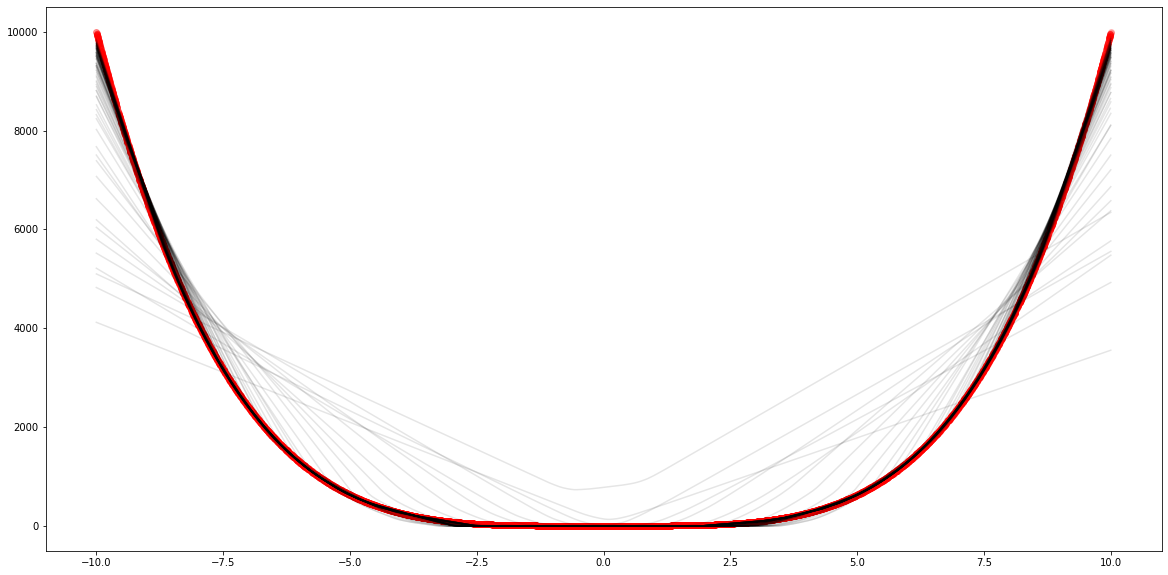

In [9]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(figsize = (20,10))

for i in convergence:
  n = 0.1
  plt.plot(i.X, i.y, alpha = n, color = "black")
  n += 0.02

plt.scatter(X_train.detach().numpy()  ,y_train.detach().numpy(), color = 'red', alpha = 0.2)